# IMPORTS

In [28]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
import folium
import folium.plugins as plugins
import imageio

import scipy.stats as stats
from datetime import datetime, timedelta
from scipy.stats import pearsonr

# LOAD DATA

In [29]:
full_fires_df = pd.read_csv('../data/California_Fire_Incidents.csv')
full_fires_df.head(1)

,AcresBurned,Active,AdminUnit,AirTankers,ArchiveYear,CalFireIncident,CanonicalUrl,ConditionStatement,ControlStatement,Counties,...,SearchKeywords,Started,Status,StructuresDamaged,StructuresDestroyed,StructuresEvacuated,StructuresThreatened,UniqueId,Updated,WaterTenders
0,257314.0,False,Stanislaus National Forest/Yosemite National Park,NaN,2013,True,/incidents/2013/8/17/rim-fire/,NaN,NaN,Tuolumne,...,"Rim Fire, Stanislaus National Forest, Yosemite...",2013-08-17T15:25:00Z,Finalized,NaN,NaN,NaN,NaN,5fb18d4d-213f-4d83-a179-daaf11939e78,2013-09-06T18:30:00Z,NaN


In [30]:
full_fires_df.shape

(1636, 40)

In [31]:
full_fires_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1636 entries, 0 to 1635
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   AcresBurned           1633 non-null   float64
 1   Active                1636 non-null   bool   
 2   AdminUnit             1636 non-null   object 
 3   AirTankers            28 non-null     float64
 4   ArchiveYear           1636 non-null   int64  
 5   CalFireIncident       1636 non-null   bool   
 6   CanonicalUrl          1636 non-null   object 
 7   ConditionStatement    284 non-null    object 
 8   ControlStatement      111 non-null    object 
 9   Counties              1636 non-null   object 
 10  CountyIds             1636 non-null   object 
 11  CrewsInvolved         171 non-null    float64
 12  Dozers                123 non-null    float64
 13  Engines               191 non-null    float64
 14  Extinguished          1577 non-null   object 
 15  Fatalities           

# DATA CLEANING

In [32]:
full_fires_df['StartDate'] = full_fires_df['Started'].apply(lambda x: pd.to_datetime(x[:10]))
# creates a date column for when the fire started.
full_fires_df['StartYear'] = full_fires_df['Started'].apply(lambda x: int(x[:4]))
# creates a year column for when the fire started.
full_fires_df['StartMonth'] = full_fires_df['Started'].apply(lambda x: int(x[5:7]))
# creates a month column for when the fire started.

In [33]:
ca_fires_df = full_fires_df[['UniqueId', 'Name', 'Counties', 'StartYear', 'StartMonth', 'StartDate', 'AcresBurned', 'Latitude', 'Longitude', 'MajorIncident']]
ca_fires_df.shape
# creates dataframe that I will work out of.

(1636, 10)

In [34]:
ca_fires_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1636 entries, 0 to 1635
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UniqueId       1636 non-null   object        
 1   Name           1636 non-null   object        
 2   Counties       1636 non-null   object        
 3   StartYear      1636 non-null   int64         
 4   StartMonth     1636 non-null   int64         
 5   StartDate      1636 non-null   datetime64[ns]
 6   AcresBurned    1633 non-null   float64       
 7   Latitude       1636 non-null   float64       
 8   Longitude      1636 non-null   float64       
 9   MajorIncident  1636 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 116.8+ KB


In [35]:
ca_fires_df = ca_fires_df.dropna(axis=0, subset=['AcresBurned'])
ca_fires_df = ca_fires_df[ca_fires_df['AcresBurned'] != 0]
ca_fires_df.shape
# removes zeros and null values from AcresBurned column.

(1605, 10)

In [36]:
ca_fires_df = ca_fires_df[(ca_fires_df['Latitude'] >= 32) & (ca_fires_df['Latitude'] <= 42) & (ca_fires_df['Longitude'] <= -114) & (ca_fires_df['Longitude'] >= -126)]
ca_fires_df.shape
# removes observations that are not in CA.

(1439, 10)

In [37]:
ca_fires_df[(ca_fires_df['Latitude'] >= 38) & (ca_fires_df['Latitude'] <= 41) & (ca_fires_df['Longitude'] <= -115) & (ca_fires_df['Longitude'] >= -118)]
ca_fires_df[ca_fires_df['Counties'] == 'State of Nevada']
# locates which observations were falling in Nevada.

,UniqueId,Name,Counties,StartYear,StartMonth,StartDate,AcresBurned,Latitude,Longitude,MajorIncident
1424,3086ac2b-bbb3-4321-81e3-3cfdb9e571e9,Jasper Fire,State of Nevada,2019,7,2019-07-13,1165.0,39.631945,-119.769881,False


In [38]:
ca_fires_df = ca_fires_df[ca_fires_df['Counties'] != 'State of Nevada']
ca_fires_df = ca_fires_df[ca_fires_df['Name'] != 'Tram Fire']
ca_fires_df.shape
# removes observations that are in Nevada.

(1437, 10)

In [39]:
ca_fires_df = ca_fires_df[ca_fires_df['StartYear'] >= 2013]
ca_fires_df.shape
# removes observations that are not in the years 2013-2019.

(1435, 10)

In [40]:
ca_fires_df['UniqueId'].nunique()
# returns number of unique fires.

1410

In [41]:
ca_fires_df = ca_fires_df.groupby('UniqueId').max().reset_index()
ca_fires_df.shape
# removes duplicate records of fires.

(1410, 10)

In [42]:
ca_fires_df.head(1)

,UniqueId,Name,Counties,StartYear,StartMonth,StartDate,AcresBurned,Latitude,Longitude,MajorIncident
0,00089805-cdee-4607-8b67-1653bee463bc,Gulch Fire,Modoc,2014,7,2014-07-03,1469.0,41.489,-120.904,True


In [43]:
ca_fires_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1410 entries, 0 to 1409
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UniqueId       1410 non-null   object        
 1   Name           1410 non-null   object        
 2   Counties       1410 non-null   object        
 3   StartYear      1410 non-null   int64         
 4   StartMonth     1410 non-null   int64         
 5   StartDate      1410 non-null   datetime64[ns]
 6   AcresBurned    1410 non-null   float64       
 7   Latitude       1410 non-null   float64       
 8   Longitude      1410 non-null   float64       
 9   MajorIncident  1410 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 100.6+ KB


In [44]:
ca_fires_df.describe()

,StartYear,StartMonth,AcresBurned,Latitude,Longitude
count,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000
mean,2016.807801,7.400709,3247.733333,37.223930,-120.274294
std,1.803497,1.749906,19507.818882,2.551992,2.003783
min,2013.000000,1.000000,2.000000,32.557546,-124.196290
25%,2016.000000,6.000000,35.250000,34.906157,-121.848938
50%,2017.000000,7.000000,100.000000,37.414110,-120.695931
75%,2018.000000,9.000000,400.000000,39.246458,-118.731552
max,2019.000000,12.000000,410203.000000,41.999341,-114.572650


# EXPLORATORY DATA ANALYSIS

## Interactive Map

In [45]:
df_copy = ca_fires_df.copy()
df_years_list = []
for year in df_copy['StartYear'].sort_values().unique():
    df_years_list.append(df_copy.loc[df_copy['StartYear']==year, ['Latitude', 'Longitude']].groupby(['Latitude', 'Longitude']).sum().reset_index().values.tolist())
# creates a list of lists where each element is a year and each element in that list element contains the latitudes and longitudes of each fire.
    
m = folium.Map(location=[34.0522, -118.2437], zoom_start=5)
plugins.HeatMapWithTime(df_years_list, index=[2013, 2014, 2015, 2016, 2017, 2018, 2019], 
                        radius=5, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(m)
m

In [46]:
# Create gif of interactive map.
images = []
filenames = ['../img/2013.png', '../img/2014.png', '../img/2015.png', '../img/2016.png', '../img/2017.png', '../img/2018.png', '../img/2019.png']
with imageio.get_writer('../img/num-fires.gif', mode='I', duration=2) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

## Number of Fires Chart

In [47]:
num_fires = ca_fires_df.groupby('StartYear')['AcresBurned'].count()
num_fires

StartYear
2013    136
2014     69
2015     91
2016    149
2017    411
2018    297
2019    257
Name: AcresBurned, dtype: int64

## Acres Burned Line Graph

In [49]:
sum_acres = ca_fires_df.groupby('StartYear')['AcresBurned'].sum()
median_acres = ca_fires_df.groupby('StartYear')['AcresBurned'].median()
max_acres = ca_fires_df.groupby('StartYear')['AcresBurned'].max()
years = sorted(ca_fires_df['StartYear'].unique())

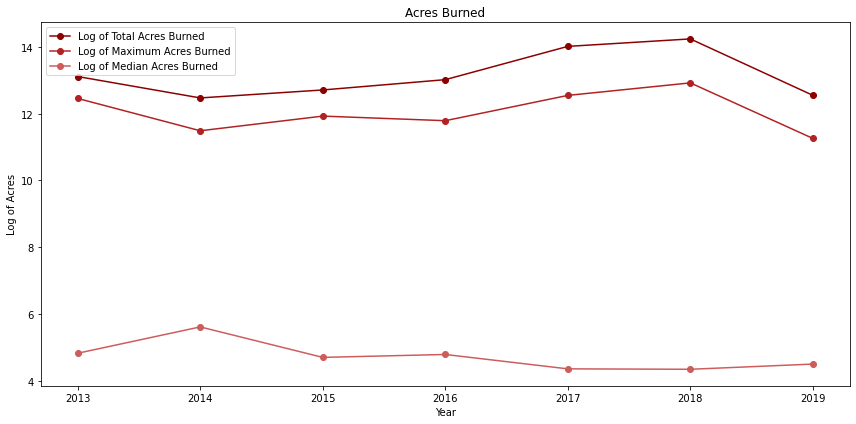

In [50]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(years, np.log(sum_acres), marker='o', color='darkred', label='Log of Total Acres Burned')
ax.plot(years, np.log(max_acres), marker='o', color='firebrick', label='Log of Maximum Acres Burned')
ax.plot(years, np.log(median_acres), marker='o', color='indianred', label='Log of Median Acres Burned')
ax.set_title('Acres Burned')
ax.set_xlabel('Year')
ax.set_ylabel('Log of Acres')
ax.legend()

plt.tight_layout()
plt.show()
# fig.savefig('../img/acres-burned-line-plot.png')

# HYPOTHESIS TEST

In [53]:
mi_lst = []
for year in years:
    mi_lst.append(ca_fires_df[ca_fires_df['StartYear']==year]['MajorIncident'])
# creates a list where each element is the data from the column, 'MajorIncident', of one year.

In [54]:
nk_dct = {}
for bool_lst in mi_lst:
    nk_dct[len(bool_lst)] = sum(bool_lst)
# creates a dictionary where the key is the number of observations in that year and the value is the number of 'MajorIncidents'.

In [55]:
post_dist = []
for n, k in nk_dct.items():
    post_dist.append(stats.distributions.beta(a = 1 + k, b = 1 + n - k))
# runs a posterior distribution for each year.

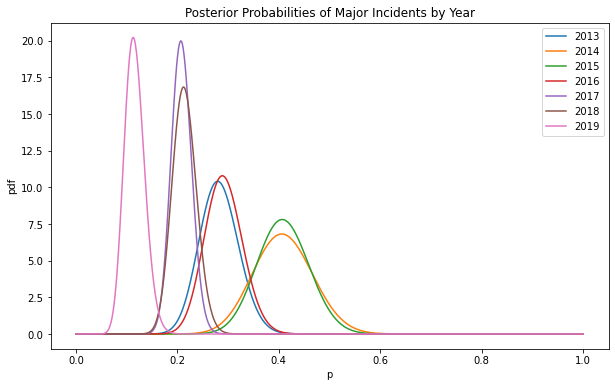

In [62]:
fig, ax = plt.subplots(figsize=(10, 6))
x = np.linspace(0,1,1000)
year_lst = [2013, 2014, 2015, 2016, 2017, 2018, 2019]
for idx, dist in enumerate(post_dist):
    ax.plot(x, dist.pdf(x), label=f'{year_lst[idx]}')
    ax.legend()
    ax.set_title('Posterior Probabilities of Major Incidents by Year')
    ax.set_xlabel('p')
    ax.set_ylabel('pdf')

# fig.savefig('../img/posterior-plots.png')

In [58]:
beta_2013 = post_dist[0]
beta_2019 = post_dist[-1]
# assigns the beta distributions of 2013 and 2019.

In [59]:
sim_2013 = beta_2013.rvs(size=10000)
sim_2019 = beta_2019.rvs(size=10000)
# creates 10,000 simulations from the 'MajorIncident' column.

In [60]:
(sim_2019 > sim_2013).mean()
# calculates what the probability is that P(MajorIncident|2019) > P(MajorIncident|2013).

0.0

In [61]:
beta_2013 = post_dist[0]
beta_2018 = post_dist[-2]
sim_2013 = beta_2013.rvs(size=10000)
sim_2018 = beta_2018.rvs(size=10000)
(sim_2018 > sim_2013).mean()
# does the same thing as above but for 2013 and 2018.

0.0588

Sources:

https://towardsdatascience.com/data-101s-spatial-visualizations-and-analysis-in-python-with-folium-39730da2adf
-showed me how to create a spatial map.

https://www.sciencemag.org/news/2020/03/us-wildfires-plummeted-2019-experts-say-it-won-t-last
-explained to me why 2019 had so few fires.

https://wildfiretoday.com/2015/11/09/was-the-2014-wildfire-season-in-california-affected-by-climate-change/
-shed some light on why 2014 had a high median for AcresBurned.

https://www.fs.usda.gov/treesearch/pubs/58973
-said they use number of fires and area burned to determine how severe a fire is.

https://stackoverflow.com/questions/753190/programmatically-generate-video-or-animated-gif-in-python
-helped make gif.